# Mapping wetland intrinsic potential and classifying types

### Background
The main function of this notebook is to utilise the trained Random Forest classifier from Notebook 4 to predict the landscape’s wetland intrinsic potential from the binary model and then classify wetland areas into classes for a specific area of interest.


In [1]:
%matplotlib inline

import os
import re
import gc
import math
import json
import time
import glob
import random
import rasterio
import datacube
import warnings
import subprocess
import numpy as np
import xarray as xr
from tqdm import tqdm
from osgeo import gdal
import rioxarray as rxr
import geopandas as gpd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from joblib import load
from odc.algo import xr_geomedian
from odc.dscache.tools import tiling
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap,BoundaryNorm
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datacube.utils.geometry import BoundingBox, Geometry
from datacube.testutils.io import rio_slurp_xarray

from classification import predict_xr
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from externaldrive import list_gdrive, read_tif_from_gdrive

## Create Dask cluster for running predictions
We use dask to parallel and speed up processing

In [2]:
# Set up a dask cluster
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 59.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34241,Workers: 1
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 59.21 GiB
Comm: tcp://127.0.0.1:35991,Total threads: 7
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/35681/status,Memory: 59.21 GiB
Nanny: tcp://127.0.0.1:38709,


In [3]:
dc = datacube.Datacube(app='wetland_classification')

## Load the model 
We use the model trained and saved in the [Train_Classification_Algorithm](04_Train_Classification_Algorithm.ipynb).

### Load area of interest (AOI)

In [4]:
prefix = 'Test'  # Specify the desired prefix - name of area of interest (aoi) is best to ensure the files have the aoi prefix when saved

# Use a polygon as a GeoJSON or Esri Shapefile. 
boundary_file = "Test.geojson" 
aoi = define_area(vector_path=boundary_file)

#Create a geopolygon and geodataframe of the area of interest
geom = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geom_gdf = gpd.GeoDataFrame(geometry=[geom], crs=geom.crs)

In [5]:
# Get the latitude and longitude range of the geopolygon
lat_range = (geom_gdf.total_bounds[1], geom_gdf.total_bounds[3])
lon_range = (geom_gdf.total_bounds[0], geom_gdf.total_bounds[2])
display_map(x=lon_range, y=lat_range)

In [6]:
# Check if both binary and type models are available
if os.path.exists(f'results/{prefix}_Binary_RF_model.joblib') and os.path.exists(f'results/{prefix}_Type_RF_model.joblib'):
    binary_model = load(f'results/{prefix}_Binary_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded binary random forest model:\n', binary_model)

    type_model = load(f'results/{prefix}_Type_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded type random forest model:\n', type_model)
elif os.path.exists(f'results/{prefix}_Binary_RF_model.joblib'):
    binary_model = load(f'results/{prefix}_Binary_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded binary random forest model:\n', binary_model)
elif os.path.exists(f'results/{prefix}_Type_RF_model.joblib'):
    type_model = load(f'results/{prefix}_Type_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded type random forest model:\n', type_model)
else:
    print("No trained models found.")


Loaded binary random forest model:
 RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=1)
Loaded type random forest model:
 RandomForestClassifier(max_features='log2', n_estimators=50, n_jobs=1,
                       random_state=1)


In [7]:
# Define the file paths for importing the feature names
binary_features_path = f"results/{prefix}_binary_model_features.json"
type_features_path = f"results/{prefix}_type_model_features.json"

# Load binary model feature names from JSON if binary model exists
if os.path.exists(binary_features_path):
    with open(binary_features_path, "r") as binary_file:
        binary_features_dict = json.load(binary_file)
    binary_feature_names = binary_features_dict["features"]
    print("Loaded binary model features.")
else:
    print("No binary model features found.")

# Load type model feature names from JSON if type model exists
if os.path.exists(type_features_path):
    with open(type_features_path, "r") as type_file:
        type_features_dict = json.load(type_file)
    type_feature_names = type_features_dict["features"]
    print("Loaded type model features.")
else:
    print("No type model features found.")


Loaded binary model features.
Loaded type model features.


### Break area of interest into tiles for smaller processing chunks

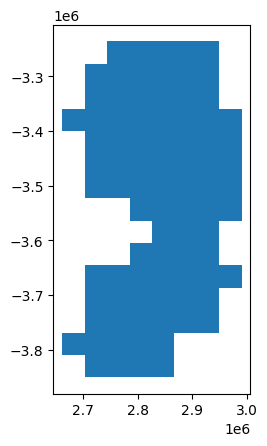

In [8]:
# Create a gridspec from string and convert to geoms
tiles = tiling.parse_gridspec(s="epsg:6933;40;1024")
tiles.tile_coords(tile_index=(0, 0))
tiles = tiles.tiles_from_geopolygon(geom)
geoms = (i[1].extent.geom for i in tiles)

geoms_df = gpd.GeoDataFrame(geometry=list(geoms))

# Set the CRS to EPSG:6933
geoms_df.crs = "EPSG:6933"

geoms_df.to_file(f"data/{prefix}_tiles.geojson", driver="GeoJSON")

# Plot the geometries
geoms_df.plot()

# Display the plot
plt.show()


### Read terrain indices from a Google Drive Folder. 
Make sure you have followed the instructions to set up the connection with [Google Drive API using a service account](https://docs.digitalearthafrica.org/en/latest/platform_tools/googledrive_access.html). This code should only be used when the terrain attribute data is located in a Google Drive to save on Sandbox disk space.

In [9]:
# # Capture the list of TIFF files from Google Drive
# tif_files = list_gdrive()

# # Initialize an empty dataset for merging
# terrain_stacked = xr.Dataset()

# # Ensure tif_files contains the expected structure
# if isinstance(tif_files, list):
#     # Filter the TIFF files from the list
#     tif_files = [file for file in tif_files if file['name'].endswith('.tif')]

#     # Display the TIFF files with their IDs
#     if tif_files:
#         print("Available TIFF files:")
#         for tif in tif_files:
#             print(f"{tif['name']} (ID: {tif['id']})")

#         # Lists to store the data arrays and their extents
#         data_arrays = []
#         extents = []
#         titles = []

#         # Read and merge all the TIFF files into the dataset
#         for tif in tif_files:
#             selected_file_id = tif['id']  # Select the current TIFF file
            
#             # Read the selected TIFF file from Google Drive
#             data_array, transform = read_tif_from_gdrive(selected_file_id)

#             # Check if the data was read successfully
#             if data_array is not None:
#                 print(f"Data for {tif['name']} read successfully!")

#                 # Convert to a dataset with the filename as the variable name
#                 tif_dataset = data_array.to_dataset(name=tif['name'].replace('.tif', ''))

#                 # Merge with the existing stacked dataset
#                 terrain_stacked = xr.merge([terrain_stacked, tif_dataset], compat='override')

#                 # Store the data array and its extent
#                 data_arrays.append(data_array)
#                 x_min, x_max = transform[2], transform[2] + transform[0] * data_array.shape[1]
#                 y_min, y_max = transform[5] + transform[4] * data_array.shape[0], transform[5]
#                 extents.append((x_min, x_max, y_min, y_max))
#                 titles.append(tif['name'])  # Store the title for the plot

#             else:
#                 print(f"Failed to read data for {tif['name']}.")

#         # Plot all TIFF data in subplots after reading them all
#         # Calculate the number of rows needed
#         num_files = len(data_arrays)
#         num_columns = 4
#         num_rows = math.ceil(num_files / num_columns)
        
#         # Create subplots with the desired number of rows and columns
#         fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

#         # Flatten the axes array for easier indexing
#         axes = axes.flatten()
        
#         # Loop through the files and plot them
#         for i in range(num_files):
#             im = axes[i].imshow(data_arrays[i], cmap='gray', extent=extents[i])
#             axes[i].set_title(titles[i])
#             axes[i].set_xlabel('X Coordinate')
#             axes[i].set_ylabel('Y Coordinate')
        
#             # Add a color bar to each subplot
#             cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)
#             cbar.set_label('Pixel Value')
        
#         # Hide axes for unused subplots if any
#         for i in range(num_files, len(axes)):
#             axes[i].axis('off')
        
#         # Adjust layout to prevent overlap
#         plt.tight_layout()
#         plt.show()

#         # Print a summary of the final merged dataset
#         print(f"Final stacked dataset contains {len(terrain_stacked.data_vars)} variables.")
#     else:
#         print("No TIFF files found.")
# else:
#     print("Failed to retrieve files from Google Drive.")

## Create the query for running the predictions

We use the query saved from the feature extraction notebook to ensure data from the same periods are retrieved. However, only selected features will be used. 

> We add `dask_chunks` to the query parameter so the data will be lazy-loaded and only the features used by the model will be calculated.

In [10]:
time = ('2022')
# using nine spectral bands with 10~20 m spatial resolution
resolution = (-20,20)
output_crs='epsg:6933'

def feature_layers(query, terrain_stacked=None): # Make sure to change None to terrain_stacked if using terrain indices from a google drive folder
    # connect to the datacube
#     dc = datacube.Datacube(app='feature_layers')
    
    # load s2 annual geomedian
    ds = dc.load(
        product='gm_s2_annual',
        measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','nir_2','swir_1','swir_2','emad','smad','bcmad'],
        **query)
    
    # calculate some band indices
    ds = calculate_indices(ds,
                           index=['NDVI', 'MNDWI','TCW'],
                           drop=False,
                           satellite_mission='s2')

    
    # Add a prefix "Annual" to the band names
    new_band_names = ['Annual_' + band_name for band_name in ds.data_vars]
    ds = ds.rename({old_band_name: new_band_name for old_band_name, new_band_name in zip(ds.data_vars, new_band_names)})

    # stack multi-temporal measurements and rename them
    n_time = ds.sizes['time']
    list_measurements = list(ds.keys())
    list_stack_measures = []
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name = list_measurements[j]+'_'+str(k)
            measure_single = ds[list_measurements[j]].isel(time=k).rename(variable_name)
            list_stack_measures.append(measure_single)
    ds_stacked = xr.merge(list_stack_measures, compat='override')

    
    # Load the Sentinel-1 data    
    ds_s1 = dc.load(product=["s1_rtc"],
                  measurements=['vv', 'vh'],
                  group_by="solar_day",
                  **query
                 )
    # Add a prefix "Sent1_" to the variables in ds_s1
    ds_s1 = ds_s1.rename({old_var: 'sentinel-1_' + old_var for old_var in ds_s1.data_vars})

    # median values are used to scale the measurements so they have a similar range for visualization
    median_s1 = ds_s1[['sentinel-1_vv','sentinel-1_vh']].median(dim='time')

    # Add ALOS L-Band Annual mosaic
    ds_alos = dc.load(product='alos_palsar_mosaic',
                      measurements=['hh','hv'],
                      **query)
    
#   Add a prefix "alos_palsar" to the variables in ds_alos
    ds_alos = ds_alos.rename({old_var: 'alos_palsar_' + old_var for old_var in ds_alos.data_vars})  
    median_alos = ds_alos[['alos_palsar_hh','alos_palsar_hv']].median(dim='time')
    

    # Add WOfS Annual summary
    wofs_annual = dc.load(product='wofs_ls_summary_annual',
               like=ds.geobox,
               time=query['time'])
    wofs_annual_frequency = wofs_annual.frequency
    wofs_annual_frequency.name = 'WOfS'
    
    
# Choose one of the following methods to load terrain attributes:

    # Option 1: Use this code if the terrain attribute files are located in a folder within the Sandbox.
    # Uncomment the code below and comment out the Google Drive option if using this method.
    # # loop through the terrain attribite files and add them to the dataset
    
    folder = os.path.join("data/terrain_attributes/", prefix)
    for filename in os.listdir(folder):
            if filename.endswith('.tif'):
                filepath = os.path.join(folder, filename)
                tif = rio_slurp_xarray(filepath, gbox=ds.geobox)
                tif = tif.to_dataset(name=filename.replace('.tif', ''))
                ds_stacked = xr.merge([ds_stacked, tif], compat='override')

    
    # Option 2: Use this code if the terrain attribute files are in a Google Drive folder
    # Uncomment the code below and comment out the Sandbox folder option above if using this method.
    # Make sure to change None to terrain_stacked in the function argument at the top if using terrain indices from a google drive folder

    # bbox = ds.geobox.extent.boundingbox
    # if terrain_stacked is not None:  
    #     terrain_stacked.attrs['crs'] = ds.geobox.crs
    #     terrain_stacked = terrain_stacked.sel(x=slice(bbox.left, bbox.right), y=slice(bbox.top, bbox.bottom))
    #     terrain_stacked = terrain_stacked.rio.reproject_match(ds)
    #     ds_stacked = xr.merge([ds_stacked, terrain_stacked], compat='override', combine_attrs='override')


    # merge all the datasets into a single dataset
    ds_stacked = xr.merge([ds_stacked, median_s1, median_alos, wofs_annual_frequency], compat='override')

    return ds_stacked

## Apply classification model to predict wetlands in the AOI

The model will be applied over each tile, producing a prediction map and a probabilities map. The maps are saved as Cloud-Optimized Geotiffs (COGs).

> Tiles are processed in sequence. For each tile, the processing needs to fit into the compute resources available in the sandbox. Make the tile size smaller if you run out of memory. For production of a map over a large region or country, consider applying for [a large sandbox (with more CPUs and momery)](
https://helpdesk.digitalearthafrica.org/portal/en/community/topic/call-for-application-for-access-to-large-sandboxes-15-processing-cores-and-120-gb-of-memory)

In [11]:
skip_existing = False
output_folder = "results"
binary_tiles_pred_folder = os.path.join(output_folder, f"{prefix}/binary_tiles_predicted")
os.makedirs(binary_tiles_pred_folder, exist_ok=True)
dask_chunks = {'x': 2500, 'y': 2500}


## Binary classification
#### Binary predictions and probabilities per tile

In [12]:
predictions = []
dask_chunks = {'x': 2500, 'y': 2500}

# Generate a datacube query object
query = {
    'geopolygon': geom,
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks': dask_chunks,
}

for index in range(len(geoms_df)):   # Iterate over the tiles
    aoi = geoms_df.iloc[index]
    progress_text = f"Predicting... Polygon {index + 1} of {len(geoms_df)}"
    print(progress_text)
    
    # Check if polygon has already been processed. If so, skip
    output_filename = os.path.join(
        binary_tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_binary_prediction.tif")
    probabilities_filename = os.path.join(
        binary_tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_binary_probabilities.tif")
    if skip_existing and os.path.exists(output_filename) and os.path.exists(probabilities_filename):
        print("Completed; Skipping")
        continue

    # Set up query based on AOI geometry
    geom = geometry.Geometry(geom=aoi.geometry, crs=geoms_df.crs)
    query.update({"geopolygon": geom})
    
    # Calculate features
    data = feature_layers(query).persist()
    
    # Only keep features that are in the original list of columns
    data = data[binary_feature_names].chunk(dask_chunks)

    # Predict using the imported model
    predicted = predict_xr(
        binary_model,
        data,
        proba=True,
        persist=True,
        clean=True,
        return_input=True
    ).persist()
    
    # Create a mask for the AOI
    print("    Getting AOI mask")
    aoi_mask = xr_rasterize(
        gdf=gpd.GeoDataFrame({"Polygon": [index], "geometry": [aoi.geometry]}, crs=geoms_df.crs),
        da=predicted,
        crs=output_crs,
    )

    # Set the no data value
    NODATA = 255

    # Mask the predictions
    print("    Preparing predictions")
    predicted_masked = (
        predicted.Predictions.where(aoi_mask == 1, NODATA)
    ).compute()
    predicted_masked.attrs["nodata"] = NODATA

    # Write predictions to COG
    print(f"    Writing predictions to {output_filename}")
    write_cog(
        predicted_masked,
        fname=output_filename,
        overwrite=True,
        nodata=NODATA,
    )

    # Mask the probabilities
    print("    Preparing probabilities")
    probability_masked = (
        predicted.Probabilities[..., :, 1].where(aoi_mask == 1, NODATA) * 100
    ).compute()
    probability_masked.attrs["nodata"] = NODATA
    probability_masked = probability_masked.where((probability_masked >= 0) & (probability_masked <= 100))

    print(f"    Writing probabilities to {probabilities_filename}")
    write_cog(
        probability_masked,
        fname=probabilities_filename,
        overwrite=True,
        nodata= NODATA
    )

    # Clear variables to free memory
    del predicted, predicted_masked, probability_masked, aoi_mask, data
    gc.collect()  # Call garbage collection to free memory

    # Clear the output
    clear_output(wait=True)


#### Merge the tiles and export the final wetland predictions and probabilities

In [13]:
prediction_tiles = f"{binary_tiles_pred_folder}/{prefix}_tile*_wetland_binary_prediction.tif"
out_mosaic_prediction = f"{output_folder}/{prefix}/{prefix}_wetland_binary_prediction.tif"

# Remove the merged file if it already exists
if os.path.exists(out_mosaic_prediction): 
    subprocess.run(f"rm {out_mosaic_prediction}", shell=True)

gdal_cmd = f"gdalwarp -of GTiff -cutline {boundary_file} -crop_to_cutline -co COMPRESS=DEFLATE {prediction_tiles} {out_mosaic_prediction}"
process = subprocess.Popen(gdal_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print("Processing wetland binary prediction:")
for line in process.stdout:
    print(f"\r{line.strip()}", end='', flush=True)  

process.wait()  
print("\rWetland binary prediction completed.")  

# Repeat for the probabilities
probabilities_tiles = f"{binary_tiles_pred_folder}/{prefix}_tile*_wetland_binary_probabilities.tif"
out_mosaic_probabilities = f"{output_folder}/{prefix}/{prefix}_wetland_binary_probabilities.tif"

# Remove the merged file if it already exists
if os.path.exists(out_mosaic_probabilities): 
    subprocess.run(f"rm {out_mosaic_probabilities}", shell=True)

gdal_cmd = f"gdalwarp -of GTiff -cutline {boundary_file} -crop_to_cutline -co COMPRESS=DEFLATE {probabilities_tiles} {out_mosaic_probabilities}"
process = subprocess.Popen(gdal_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print("Processing wetland binary probabilities:")
for line in process.stdout:
    print(f"\r{line.strip()}", end='', flush=True)  

process.wait()  # Wait for the process to finish
print("\rWetland binary probabilities completed.") 

# Load the merged predictions and probababilities as xarray DataArray
merged_prediction = rxr.open_rasterio(out_mosaic_prediction).squeeze()
merged_probabilities = rxr.open_rasterio(out_mosaic_probabilities).squeeze()

# Rasterize the area of interest polygon
aoi_raster = xr_rasterize(gdf=geom_gdf,
                          da=merged_prediction,
                          crs=merged_prediction.rio.crs)


# Mask the wetland classes pixels within the AOI
binary_wetland_predictions = merged_prediction.where((~np.isnan(merged_prediction)) & (aoi_raster != 0))

# Define the output clipped filenames
clipped_prediction_file = f"{output_folder}/{prefix}/{prefix}_wetland_binary_prediction.tif"
clipped_probabilities_file = f"{output_folder}/{prefix}/{prefix}_wetland_binary_probabilities.tif"

# Write the clipped wetland predictions to file
write_cog(binary_wetland_predictions, fname=clipped_prediction_file, overwrite=True)

# Clip the wetland probabilities to the AOI
binary_wetland_probabilities = merged_probabilities.where((~np.isnan(merged_probabilities)) & (merged_probabilities != 255) & (aoi_raster != 0))

# Write the clipped wetland probabilities to file
write_cog(binary_wetland_probabilities, fname=clipped_probabilities_file, overwrite=True)

Processing wetland binary prediction:
Wetland binary prediction completed._tiles_predicted/SANBI_Test_tile085_wetland_binary_prediction.tif [86/86] : 0...10...20...30...40...50...60...70...80...90...100 - done.results/SANBI_Test/binary_tiles_predicted/SANBI_Test_tile062_wetland_binary_prediction.tif [63/86] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing wetland binary probabilities:
Wetland binary probabilities completed.0...90...100 - done.Test_tile085_wetland_binary_probabilities.tif [86/86] : 0Using internal nodata values (e.g. 255) for image results/SANBI_Test/binary_tiles_predicted/SANBI_Test_tile085_wetland_binary_probabilities.tif.I_Test_tile062_wetland_binary_probabilities.tif.


PosixPath('results/SANBI_Test/SANBI_Test_wetland_binary_probabilities.tif')

#### Plot the wetland predicition and probabilities

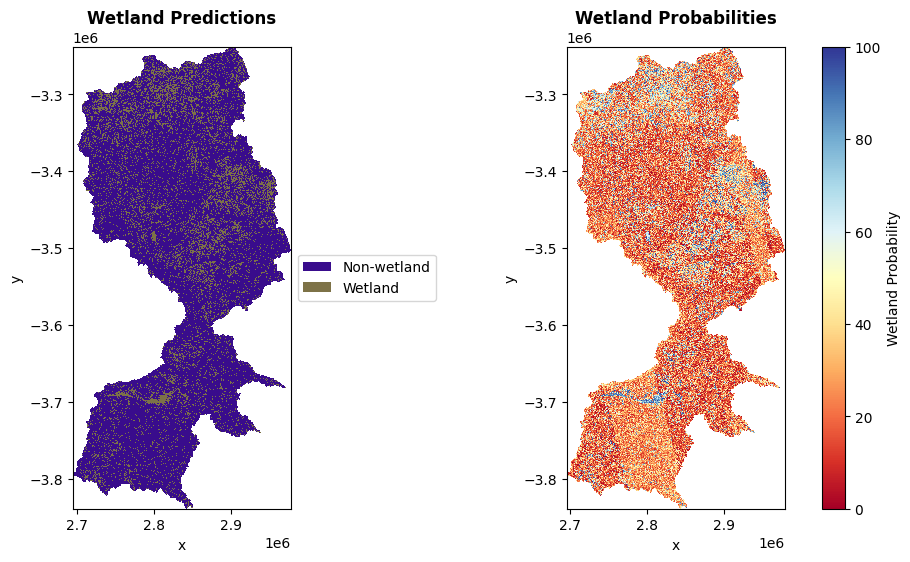

In [14]:
# Create a new label dictionary
labels_dict_binary = {'Non-wetland': 0, 'Wetland': 1}

# Generate random colors for each class (excluding class 0)
random.seed(42)  # Set a seed for reproducibility
class_colors = {class_name: f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'
                for class_name in labels_dict_binary}

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size if needed

# Plot wetland predictions
sorted_classes = sorted(labels_dict_binary, key=lambda x: labels_dict_binary[x])
cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])

# Plot wetland predictions
binary_wetland_predictions.plot.imshow(ax=axes[0],
                                        cmap=cmap,
                                        add_colorbar=False,
                                        interpolation='none')  
axes[0].set_title('Wetland Predictions', fontweight='bold')
axes[0].set_aspect('equal')

# Plot clipped wetland probabilities
im = binary_wetland_probabilities.plot.imshow(ax=axes[1],
                                               cmap='RdYlBu',
                                               add_colorbar=False,
                                               interpolation='none')
axes[1].set_title('Wetland Probabilities', fontweight='bold')
axes[1].set_aspect('equal') 

# Add legend to the first subplot
patches_list = [Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes]
legend = axes[0].legend(patches_list, [class_name for class_name in sorted_classes],
                        loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust spacing
plt.subplots_adjust(wspace=0.4) 

# Add colorbar outside the subplot
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label('Wetland Probability')

plt.show()


### Independent accuaracy assessment 

In [ ]:
# Load the testing points GeoDataFrame
testing_points = gpd.read_file(f'data/{prefix}_testing_samples.geojson')

# Replace non-zero values in the 'class_id' column with 1
testing_points['class_id_binary'] = testing_points['class_id'].apply(lambda x: 1 if x != 0 else 0)
# Insert the new column at the second position
testing_points.insert(1, 'class_id_binary', testing_points.pop('class_id_binary'))

# Sample the predictions and probabilities at testing points
sampled_predictions = []
sampled_probabilities = []

for point in testing_points.geometry:
    # Extract the point coordinates
    x, y = point.x, point.y
    
    # Sample the binary predictions and probabilities at the point coordinates
    prediction = binary_wetland_predictions.sel(x=x, y=y, method='nearest').item()
    probability = binary_wetland_probabilities.sel(x=x, y=y, method='nearest').item()
    
    # Append the sampled values
    sampled_predictions.append(prediction)
    sampled_probabilities.append(probability)

# Add the sampled values as new columns in the GeoDataFrame
testing_points['sampled_predictions'] = sampled_predictions
testing_points['sampled_probabilities'] = sampled_probabilities

# Calculate the number of correctly classified samples
correct_count = (testing_points['sampled_predictions'] == testing_points['class_id_binary']).sum()

# Calculate the total number of samples
total_count = len(testing_points)

# Calculate the accuracy as a percentage
accuracy_percentage = (correct_count / total_count) * 100

# Print the accuracy percentage
print(f"Overall Accuracy: {accuracy_percentage:.2f}%")


## Wetland Type classification
#### Applied to the wetland class

In [ ]:
thresholded_binary_wetland_probabilities = binary_wetland_probabilities.where(binary_wetland_probabilities >= 50)

# Check if type_model exists
if 'type_model' in locals():   
    tiles_pred_folder = os.path.join(output_folder, f"{prefix}/type_tiles_predicted")
    os.makedirs(tiles_pred_folder, exist_ok=True)

    predictions = []
    dask_chunks = {'x':2500,'y':2500}

    # generate a datacube query object
    query = {
        'geopolygon': geom,
        'time': time,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks': dask_chunks,
    }

    for index in range(len(geoms_df)):   # Iterate over the tiles
        aoi = geoms_df.iloc[index]
    #     print(f"Processing Polygon {index + 1} of {len(geoms_df)}")
        progress_text = f"Predicting... Polygon {index + 1} of {len(geoms_df)}"
        print(progress_text)

        # Check if polygon has already been processed. If so, skip
        output_filename = os.path.join(
            tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_type_prediction.tif")
        probabilities_filename = os.path.join(
            tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_type_probabilities.tif")
        if skip_existing and os.path.exists(output_filename) and os.path.exists(probabilities_filename):
            print("Completed; Skipping")
            continue

        # set up query based on aoi geometry
        geom = geometry.Geometry(geom=aoi.geometry, crs=geoms_df.crs)
        query.update({"geopolygon": geom})

        # set the no data value
        NODATA = 255

        # calculate features
        data = feature_layers(query).persist()

        # Clip the data to the extent of wetland predictions
#         data = data.where(binary_wetland_predictions == 1)
        data = data.where(thresholded_binary_wetland_probabilities != 0)

        # Only keep features that are in the original list of columns
        data = data[type_feature_names]

        # Convert xarray Dataset object to Dask array
        data_dask = data.chunk(dask_chunks)

        # predict using the imported model
        predicted = predict_xr(type_model,
                               data_dask,
                               proba=True,
                               persist=True,
                               clean=True,
                               return_input=True
                               ).compute().persist()

        # Create a mask for the aoi
        print("    Getting AOI mask")
        aoi_mask = xr_rasterize(
            gdf=gpd.GeoDataFrame({"Polygon": [index], "geometry": [
                                 aoi.geometry]}, crs=geoms_df.crs),
            da=predicted,
            crs=output_crs,
        )


        # Mask the predictions with both AOI mask and wetland predictions mask
        print("    Preparing predictions")
        predicted_masked = (
            predicted.Predictions.where((aoi_mask == 1) & (binary_wetland_predictions == 1), NODATA)
        )
        predicted_masked.attrs["nodata"] = NODATA
        predicted_masked = predicted_masked.where(thresholded_binary_wetland_probabilities != 0)
                                                  
        # Write predictions to COG
        print(f"    Writing predictions to {output_filename}")
        write_cog(
            predicted_masked,
            fname=output_filename,
            overwrite=True,
            nodata=255,
        )
        
        # Mask the probabilities with both AOI mask and wetland predictions mask
        probability_masked = (
            predicted.Probabilities.max().where((aoi_mask == 1) & (binary_wetland_predictions == 1), NODATA) * 100
        )
        probability_masked.attrs["nodata"] = NODATA
        probability_masked = probability_masked.where((probability_masked >= 0) & (probability_masked <= 100))

        print(f"    Writing probabilities to {probabilities_filename}")
        write_cog(
            probability_masked,
            fname=probabilities_filename,
            overwrite=True,
            nodata=255,
        )

        # Clear variables to free memory
        del predicted, predicted_masked, probability_masked, aoi_mask, data
        gc.collect()  # Call garbage collection to free memory
    
        # Clear the output
        clear_output(wait=True)
else:
    print("Skipping prediction process as wetland type model is not available.")             

#### Merge the tiles and export the final wetland predicitons and probabilities

In [ ]:
tiles_pred_folder = os.path.join(output_folder, f"{prefix}/type_tiles_predicted")
# Check if type_model exists
if 'type_model' in locals():
    prediction_tiles = f"{tiles_pred_folder}/{prefix}_tile*_wetland_type_prediction.tif"
    out_mosaic_prediction = f"{output_folder}/{prefix}/{prefix}_wetland_type_prediction.tif"
    
    # Remove the merged file if it already exists
    if os.path.exists(out_mosaic_prediction): 
        subprocess.run(f"rm {out_mosaic_prediction}", shell=True)
    
    gdal_cmd = f"gdalwarp -of GTiff -cutline {boundary_file} -crop_to_cutline -co COMPRESS=DEFLATE -dstnodata 255 {prediction_tiles} {out_mosaic_prediction}"
    process = subprocess.Popen(gdal_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    print("Processing wetland type prediction:")
    for line in process.stdout:
        print(f"\r{line.strip()}", end='', flush=True)  
    
    process.wait()  
    print("\rWetland type prediction completed.")  
    
    # # Repeat for the probabilities
    probabilities_tiles = f"{tiles_pred_folder}/{prefix}_tile*_wetland_type_probabilities.tif"
    out_mosaic_probabilities = f"{output_folder}/{prefix}/{prefix}_wetland_type_probabilities.tif"
    
    # Remove the merged file if it already exists
    if os.path.exists(out_mosaic_probabilities): 
        subprocess.run(f"rm {out_mosaic_probabilities}", shell=True)
    
    gdal_cmd = f"gdalwarp -of GTiff -cutline {boundary_file} -crop_to_cutline -co COMPRESS=DEFLATE -dstnodata 255 {probabilities_tiles} {out_mosaic_probabilities}"
    process = subprocess.Popen(gdal_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    print("Processing wetland type probabilities:")
    for line in process.stdout:
        print(f"\r{line.strip()}", end='', flush=True)  
    
    process.wait()  # Wait for the process to finish
    print("\rWetland type probabilities completed.") 


# Load the merged predictions and probababilities as xarray DataArray
# Mask NoData in the merged predictions and probabilities
merged_prediction = rxr.open_rasterio(out_mosaic_prediction, masked=True).squeeze().where(lambda x: x != 255)
merged_probabilities = rxr.open_rasterio(out_mosaic_probabilities, masked=True).squeeze().where(lambda x: x != 255)

# Rasterize the area of interest polygon
aoi_raster = xr_rasterize(gdf=geom_gdf,
                          da=merged_prediction,
                          crs=merged_prediction.rio.crs)


# Mask the wetland classes pixels within the AOI
wetland_type_predictions = merged_prediction.where((~np.isnan(merged_prediction)) & (merged_probabilities != 255))

# Define the output clipped filenames
clipped_prediction_file = f"{output_folder}/{prefix}/{prefix}_wetland_type_prediction.tif"
clipped_probabilities_file = f"{output_folder}/{prefix}/{prefix}_wetland_type_probabilities.tif"

# Write the clipped wetland predictions to file
write_cog(wetland_type_predictions, fname=clipped_prediction_file, overwrite=True)

# Clip the wetland probabilities to the AOI
wetland_type_probabilities = merged_probabilities.where((~np.isnan(merged_probabilities)) & (merged_probabilities != 255))

# Write the clipped wetland probabilities to file
write_cog(wetland_type_probabilities, fname=clipped_probabilities_file, overwrite=True)


#### Plot the wetland type predicitions and probabilities¶

In [ ]:
# Check if type_model exists
if 'type_model' in locals():
    # Import the class label dictionary
    with open(f'data/{prefix}_labels_dict.json', 'r') as json_file:
        labels_dict = json.load(json_file)
        # Remove the non-wetland class from the dictionary
        if 'Non-wetland' in labels_dict:
            del labels_dict['Non-wetland']    

    # Generate random colors for each class (excluding class 0)
    random.seed(42)  # Set a seed for reproducibility
    class_colors = {class_name: f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'
                    for class_name in labels_dict}

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Sort classes based on their numeric labels
    sorted_classes = sorted(labels_dict, key=lambda x: labels_dict[x])

    # Define color map for the wetland type predictions
    cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])

    # Plot wetland type predictions
    wetland_type_predictions.plot.imshow(ax=axes[0],
                                         cmap=cmap,
                                         add_colorbar=False,
                                         interpolation='none')
    axes[0].set_title('Wetland Types', fontweight='bold')
    axes[0].set_aspect('equal')

    # Plot clipped wetland probabilities
    im = wetland_type_probabilities.plot.imshow(ax=axes[1],
                                                cmap='RdYlBu',
                                                add_colorbar=False,
                                                interpolation='none')
    axes[1].set_title('Wetland Probabilities', fontweight='bold')
    axes[1].set_aspect('equal')

    # Add legend to the first subplot
    patches_list = [Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes]
    legend = axes[0].legend(patches_list, [class_name for class_name in sorted_classes],
                            loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust spacing
    plt.subplots_adjust(wspace=0.4) 

    # Add colorbar outside the subplot
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
    cbar.set_label('Wetland Probability')

    plt.show()
else:
    print("Skipping plotting process as wetland type model is not available.") 


### Independent accuaracy assessment 

In [ ]:
# Check if type_model exists
if 'type_model' in locals():
# Load the testing points GeoDataFrame
    testing_points = gpd.read_file(f'data/{prefix}_testing_samples.geojson')

    # Sample the predictions and probabilities at testing points
    sampled_predictions = []
    sampled_probabilities = []

    for point in testing_points.geometry:
        # Extract the point coordinates
        x, y = point.x, point.y

        # Sample the binary predictions at the point coordinates
        prediction = wetland_type_predictions.sel(x=x, y=y, method='nearest').item()

        # Append the sampled values
        sampled_predictions.append(prediction)

    # Add the sampled values as new columns in the GeoDataFrame
    testing_points['sampled_predictions'] = sampled_predictions
    
    # Remove rows with NaN values for sampled predictions
    testing_points = testing_points.dropna(subset=['sampled_predictions'])

    # Calculate the number of correctly classified samples
    correct_count = (testing_points['sampled_predictions'] == testing_points['class_id']).sum()

    # Calculate the total number of samples
    total_count = len(testing_points)

    # Calculate the accuracy as a percentage
    accuracy_percentage = (correct_count / total_count) * 100

    # Print the accuracy percentage
    print(f"Overall Accuracy: {accuracy_percentage:.2f}%")
else:
    print("Skipping accuracy calculation as wetland type model is not available.") 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')